In [5]:
from cells.bind import VertexModel

import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from pathlib import Path
from operator import itemgetter

sys.path.append("analysis/utils/")
import config_functions   as config
import vm_output_handling as vm_output
from plot_utils import hist_to_curve

sys.path.append("analysis/experimental/")
from data_class import SegmentationData

In [6]:
# LOAD EXPERIMENTAL DATA
binsize = 200
density = 1900

masks = []
cellprops = []

# Add experimental data
for dataset in ["holomonitor_20240319_A1-13",
                "holomonitor_20240301_B1-4"]:
                #"holomonitor_20240319_B1-11",
                #"holomonitor_20240319_A1-9",
                #"holomonitor_20240319_A1-13"]:

    cellprop = SegmentationData()
    cellprop.load(f"data/experimental/processed/{dataset}/cell_props.p")
    cellprop.add_density()

    mask = (cellprop.density > density - binsize / 2) * (cellprop.density < density + binsize / 2)

    masks.append(mask)
    cellprops.append(cellprop)

State loaded from data/experimental/processed/holomonitor_20240319_A1-13/cell_props.p.
State loaded from data/experimental/processed/holomonitor_20240301_B1-4/cell_props.p.


In [132]:
# LOAD SIMULATION DATA
date  = 20251127
gamma = 6
v0   = 40
tau  = 100
eta  = 100

arr = [100]

paths = [f"data/simulated/raw/nodivision_{date}_N42_L600_gamma{gamma}_v0{v0}_taup{tau}_eta{eta}.p" for tau in arr]

list_vms = []
for filepath in paths:
    config_path = f"data/simulated/configs/{Path(filepath).stem}.json"
    config_file = config.load(config_path)

    # Compute time period between frames
    dt = config_file["simulation"]["dt"]
    T  = config_file["simulation"]["period"]
    df = T * dt

    # Load frames as vm objects
    list_vm, init_vm = vm_output.load(filepath, df=df)
    list_vms.append(list_vm)


In [97]:
# # GET CELL PROPERTIES
# cell_heights       = vm_output.get_cell_heights(list_vm)
# cell_volumes       = vm_output.get_cell_volumes(list_vm)
# cell_velocities    = vm_output.get_cell_velocities(list_vm)
# cell_aspect_ratios = vm_output.get_cell_aspect_ratios(list_vm)

# cell_areas      = cell_volumes / cell_heights
# cell_speeds     = np.sqrt(cell_velocities[:,:,0]**2 + cell_velocities[:,:,1]**2)

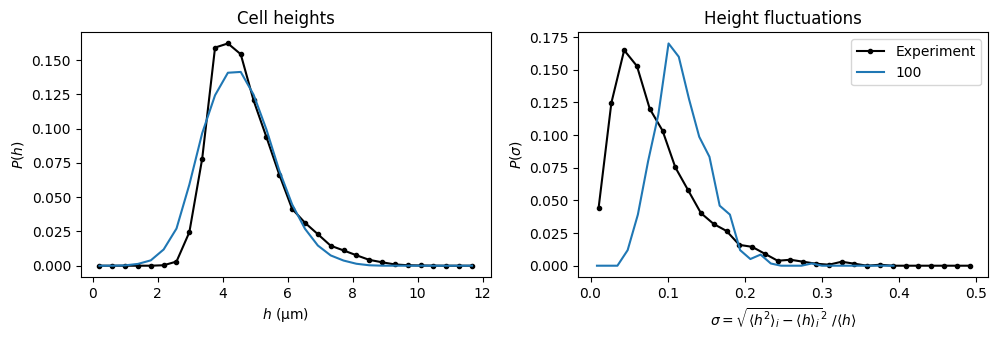

In [133]:
# experiment
tmp_dist  = []
tmp_std   = []

# combine data from all experiments
for cellprop, mask in zip(cellprops, masks):
    tmp_dist.append(        (cellprop.h[mask]).ravel())
    tmp_std.append(np.ma.std(cellprop.h[mask], axis=0))

tmp_dist  = np.ma.concatenate(tmp_dist)
tmp_std   = np.ma.concatenate(tmp_std)

# get histogram curves
dist_exp = hist_to_curve(tmp_dist, 30, hist_range=[1e-2, 2.5*np.ma.mean(tmp_dist)])
std_exp  = hist_to_curve(tmp_std,  30, hist_range=[1e-2,     np.ma.mean(tmp_dist)/2])

# get data from all simulations
dist_sim = []
std_sim  = []
for list_vm in list_vms:
    cell_heights = vm_output.get_cell_heights(list_vm)

    # get histogram curves
    dist_sim.append(hist_to_curve(cell_heights, 30, hist_range=[1e-2, 2.5*np.ma.mean(tmp_dist)]))
    std_sim.append(hist_to_curve(np.ma.std(cell_heights, axis=0), 30, hist_range=[1e-2, np.ma.mean(tmp_dist) / 2]))


# normalize experimental data
y_scaled_dist_exp = dist_exp[1] / np.ma.sum(dist_exp[1])
y_scaled_std_exp  = std_exp[1]  / np.ma.sum(std_exp[1])

# shift fluctuations by mean value
x_scaled_dist_exp = dist_exp[0]
x_scaled_std_exp  = std_exp[0]  / np.ma.mean(tmp_dist)

# create figure
plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.title("Cell heights")
plt.xlabel(r"$h$ (µm)")
plt.ylabel(r"$P(h)$")

# plot experimental
plt.plot(x_scaled_dist_exp, y_scaled_dist_exp, 'k.-', label="Experiment")

# plot simulation
for i in range(len(paths)):
    x_scaled_dist_sim = dist_sim[i][0]
    y_scaled_dist_sim = dist_sim[i][1] / np.ma.sum(dist_sim[i][1])
    plt.plot(x_scaled_dist_sim, y_scaled_dist_sim, label=arr[i])

# create subfigure
plt.subplot(122)
plt.title("Height fluctuations")
plt.xlabel(r"$\sigma=\sqrt{\langle h^2 \rangle_i - \langle h \rangle_i}^2~/ \langle h \rangle$")
plt.ylabel(r"$P(\sigma)$")

# plot experimental
plt.plot(x_scaled_std_exp, y_scaled_std_exp, 'k.-', label="Experiment")

# plot simulation
for i in range(len(paths)):
    y_scaled_std_sim = std_sim[i][1] / np.ma.sum(std_sim[i][1])
    x_scaled_std_sim = std_sim[i][0] / np.ma.mean(dist_sim[i][0])
    plt.plot(x_scaled_std_sim, y_scaled_std_sim, label=arr[i])

# save
plt.legend()
plt.tight_layout()
#plt.savefig("cell_heights_gamma50.png", dpi=300)

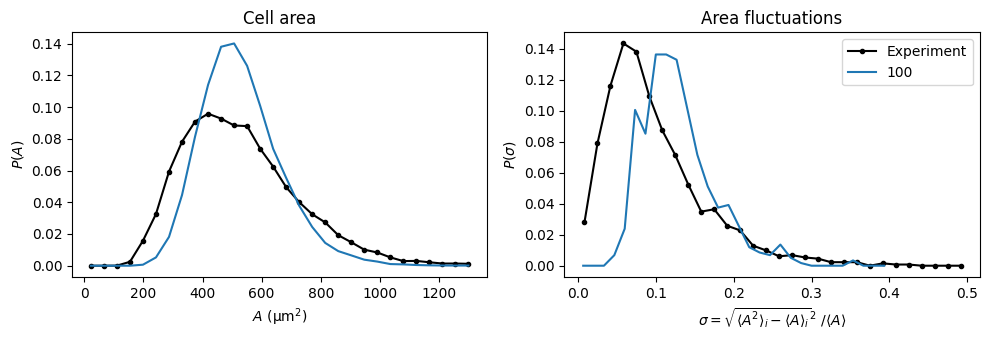

In [134]:
# experiment
tmp_dist  = []
tmp_std   = []

# combine data from all experiments
for cellprop, mask in zip(cellprops, masks):
    tmp_dist.append(        (cellprop.A[mask]).ravel())
    tmp_std.append(np.ma.std(cellprop.A[mask], axis=0))

tmp_dist  = np.ma.concatenate(tmp_dist)
tmp_std   = np.ma.concatenate(tmp_std)

# get histogram curves
dist_exp = hist_to_curve(tmp_dist, 30, hist_range=[1e-2, 2.5*np.ma.mean(tmp_dist)])
std_exp  = hist_to_curve(tmp_std,  30, hist_range=[1e-2, np.ma.mean(tmp_dist) / 2])

# get data from all simulations
dist_sim = []
std_sim  = []
for list_vm in list_vms:
    cell_heights = vm_output.get_cell_heights(list_vm)
    cell_volumes = vm_output.get_cell_volumes(list_vm)
    cell_areas   = cell_volumes / cell_heights

    # get histogram curves
    dist_sim.append(hist_to_curve(cell_areas,                    30, hist_range=[1e-2, 2.5*np.ma.mean(tmp_dist)]))
    std_sim.append( hist_to_curve(np.ma.std(cell_areas, axis=0), 30, hist_range=[1e-2, np.ma.mean(tmp_dist) / 2]))


# normalize experimental data
y_scaled_dist_exp = dist_exp[1] / np.ma.sum(dist_exp[1])
y_scaled_std_exp  = std_exp[1]  / np.ma.sum(std_exp[1])

# shift fluctuations by mean value
x_scaled_dist_exp = dist_exp[0]
x_scaled_std_exp  = std_exp[0]  / np.ma.mean(tmp_dist)

# create figure
plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.title("Cell area")
plt.xlabel(r"$A$ (µm$^2$)")
plt.ylabel(r"$P(A)$")

# plot experimental
plt.plot(x_scaled_dist_exp, y_scaled_dist_exp, 'k.-', label="Experiment")

# plot simulation
for i in range(len(paths)):
    x_scaled_dist_sim = dist_sim[i][0]
    y_scaled_dist_sim = dist_sim[i][1] / np.ma.sum(dist_sim[i][1])
    plt.plot(x_scaled_dist_sim, y_scaled_dist_sim, label=arr[i])

# create subfigure
plt.subplot(122)
plt.title("Area fluctuations")
plt.xlabel(r"$\sigma=\sqrt{\langle A^2 \rangle_i - \langle A \rangle_i}^2~/ \langle A \rangle$")
plt.ylabel(r"$P(\sigma)$")

# plot experimental
plt.plot(x_scaled_std_exp, y_scaled_std_exp, 'k.-', label="Experiment")

# plot simulation
for i in range(len(paths)):
    y_scaled_std_sim = std_sim[i][1] / np.ma.sum(std_sim[i][1])
    x_scaled_std_sim = std_sim[i][0] / np.ma.mean(dist_sim[i][0])
    plt.plot(x_scaled_std_sim, y_scaled_std_sim, label=arr[i])

# save
plt.legend()
plt.tight_layout()
#plt.savefig("cell_areas_gamma50.png", dpi=300)

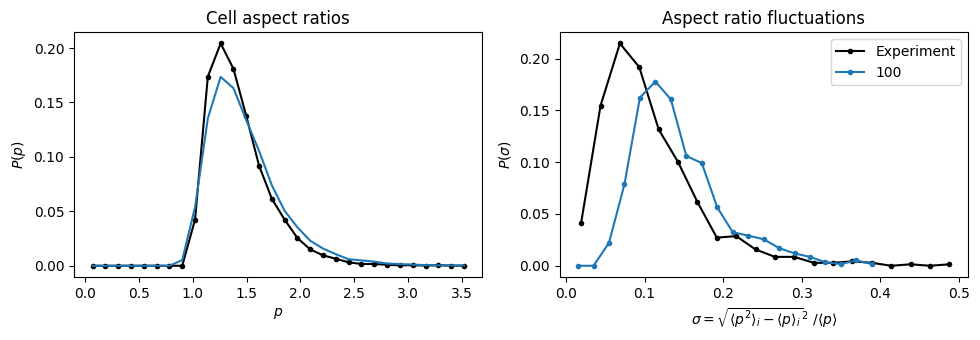

In [135]:
# experiment
tmp_dist  = []
tmp_std   = []

# # combine data from all experiments
# for cellprop, mask in zip(cellprops, masks):
#     tmp_dist.append(        (cellprop.A[mask]).ravel())
#     tmp_std.append(np.ma.std(cellprop.A[mask], axis=0))

tmp_dist.append(     (cellprops[0].amajor[masks[0]] / cellprops[0].aminor[masks[0]]).ravel())
tmp_std.append(np.std(cellprops[0].amajor[masks[0]] / cellprops[0].aminor[masks[0]], axis=0))

tmp_dist  = np.ma.concatenate(tmp_dist)
tmp_std   = np.ma.concatenate(tmp_std)

# get histogram curves
dist_exp = hist_to_curve(tmp_dist, 30, hist_range=[1e-2, 2.5*np.ma.mean(tmp_dist)])
std_exp  = hist_to_curve(tmp_std,  20, hist_range=[1e-2, np.ma.mean(tmp_dist) / 2])

# get data from all simulations
dist_sim = []
std_sim  = []
for list_vm in list_vms:
    cell_aspect_ratios = vm_output.get_cell_aspect_ratios(list_vm)

    # get histogram curves
    dist_sim.append(hist_to_curve(cell_aspect_ratios,                    30, hist_range=[1e-2, 2.5*np.ma.mean(tmp_dist)]))
    std_sim.append( hist_to_curve(np.ma.std(cell_aspect_ratios, axis=0), 20, hist_range=[1e-2, np.ma.mean(tmp_dist) / 2]))


# normalize experimental data
y_scaled_dist_exp = dist_exp[1] / np.ma.sum(dist_exp[1])
y_scaled_std_exp  = std_exp[1]  / np.ma.sum(std_exp[1])

# shift fluctuations by mean value
x_scaled_dist_exp = dist_exp[0]
x_scaled_std_exp  = std_exp[0]  / np.ma.mean(tmp_dist)

# create figure
plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.title("Cell aspect ratios")
plt.xlabel(r"$p$")
plt.ylabel(r"$P(p)$")

# plot experimental
plt.plot(x_scaled_dist_exp, y_scaled_dist_exp, 'k.-', label="Experiment")

# plot simulation
for i in range(len(paths)):
    x_scaled_dist_sim = dist_sim[i][0]
    y_scaled_dist_sim = dist_sim[i][1] / np.ma.sum(dist_sim[i][1])
    plt.plot(x_scaled_dist_sim, y_scaled_dist_sim, label=arr[i])

# create subfigure
plt.subplot(122)
plt.title("Aspect ratio fluctuations")
plt.xlabel(r"$\sigma=\sqrt{\langle p^2 \rangle_i - \langle p \rangle_i}^2~/ \langle p \rangle$")
plt.ylabel(r"$P(\sigma)$")

# plot experimental
plt.plot(x_scaled_std_exp, y_scaled_std_exp, 'k.-', label="Experiment")

# plot simulation
for i in range(len(paths)):
    y_scaled_std_sim = std_sim[i][1] / np.ma.sum(std_sim[i][1])
    x_scaled_std_sim = std_sim[i][0] / np.ma.mean(dist_sim[i][0])
    plt.plot(x_scaled_std_sim, y_scaled_std_sim, '.-', label=arr[i])

# save
plt.legend()
plt.tight_layout()
#plt.savefig("cell_aspect_ratio_gamma50.png", dpi=300)


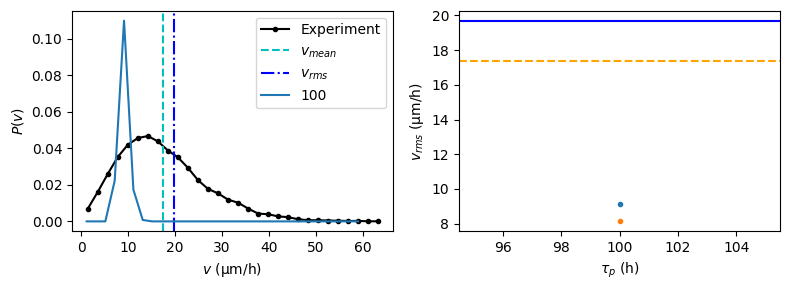

In [136]:
tmp_speed = []
tmp_vrms  = []
for cellprop, mask in zip(cellprops, masks):
    speed     = np.ma.sqrt(cellprop.dx[mask[:-1]]**2 + cellprop.dy[mask[:-1]]**2) * 12
    vrms_cell = np.ma.sqrt(np.ma.mean(speed**2, axis=0))
    vrms_tot  = np.ma.sqrt(np.ma.mean(speed**2))

    tmp_speed.append(speed.ravel())
    tmp_vrms.append(vrms_cell.ravel())

tmp_speed = np.ma.concatenate(tmp_speed)
speed_exp = hist_to_curve(tmp_speed, 30)

speed_sims  = []
cell_speeds = []
for list_vm in list_vms:

    velocities = vm_output.get_cell_velocities(list_vm)
    speeds     = np.sqrt(velocities[:,:,0]**2 + velocities[:,:,1]**2)
    cell_speeds.append(speeds)
    speed_sims.append(hist_to_curve(np.sqrt(np.ma.mean(speeds**2, axis=0)), 30, hist_range=[0.1, 60]))



plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(speed_exp[0], speed_exp[1],                 'k.-', label="Experiment")
plt.axvline(np.mean(tmp_speed),             c="c", ls="--", label=r"$v_{mean}$")
plt.axvline(np.sqrt(np.mean(tmp_speed**2)), c="b", ls="-.", label=r"$v_{rms}$")

i = 0
for speed_sim in speed_sims:
    plt.plot(speed_sim[0], speed_sim[1] * 0.3, label=arr[i])

    i += 1

plt.legend()
plt.xlabel(r"$v$ (µm/h)")
plt.ylabel(r"$P(v)$")
plt.tight_layout()

plt.subplot(122)
plt.axhline(np.sqrt(np.mean(tmp_speed**2)), c="b", ls="-", label=r"$v_{rms}$")
plt.axhline(np.mean(tmp_speed), c="orange", ls="--", label=r"$v_{rms}$")
plt.plot(arr, [np.sqrt(np.mean(np.array(speed)**2)) for speed in cell_speeds], '.')
plt.plot(arr, [np.mean(np.array(speed)) for speed in cell_speeds], '.')
plt.tight_layout()
plt.xlabel(r"$\tau_p$ (h)")
plt.ylabel(r"$v_{rms}$ (µm/h)")
plt.tight_layout()
#plt.savefig("speed_distribution_gamma50.png", dpi=300)

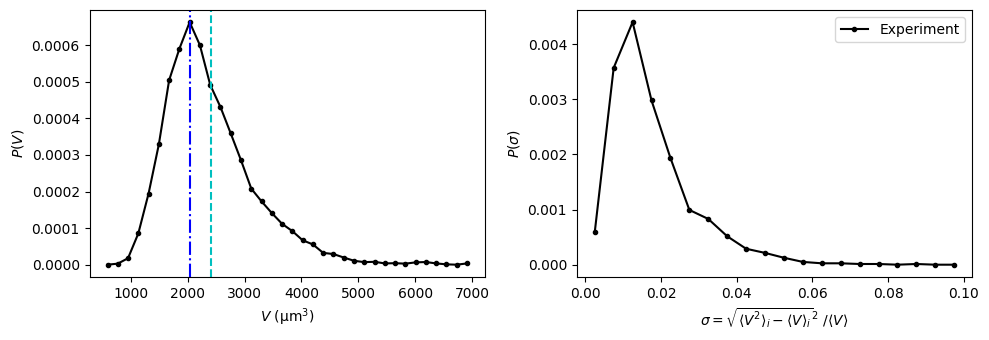

In [137]:
# experiment
tmp_dist = []
tmp_std  = []
for cellprop, mask in zip(cellprops, masks):
    tmp_dist.append(     (cellprop.A[mask] * cellprop.h[mask]).ravel())
    tmp_std.append(np.ma.std(cellprop.A[mask] * cellprop.h[mask], axis=0))

tmp_dist = np.ma.concatenate(tmp_dist)
tmp_std  = np.ma.concatenate(tmp_std)

dist_exp = hist_to_curve(tmp_dist, 36, hist_range=[500, 7000])
std_exp  = hist_to_curve(tmp_std,  20, hist_range=[1e-2, np.ma.mean(tmp_dist)/2])
    
# normalize
scaled_std_exp  = std_exp[0] / np.ma.mean(tmp_dist)
scaled_std_exp /= np.ma.sum(scaled_std_exp)


plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.plot(dist_exp[0], dist_exp[1],               'k.-', label="Experiment")
plt.axvline(np.mean(tmp_dist),                   c="c", ls='--', label="Mean")
plt.axvline(dist_exp[0][np.argmax(dist_exp[1])], c="b", ls='-.', label="Max")
plt.xlabel(r"$V$ (µm$^3$)")
plt.ylabel(r"$P(V)$")

plt.subplot(122)
plt.plot(scaled_std_exp, std_exp[1], 'k.-', label="Experiment")
# for i in range(len(paths)):
#     scaled_std_sim = std_sim[i][0] / np.ma.mean(dist_sim[i][0])
#     scaled_std_sim /= np.ma.sum(scaled_std_sim)
#     plt.plot(scaled_std_sim, std_sim[i][1], label="Simulation")
plt.legend()
plt.legend()
plt.xlabel(r"$\sigma=\sqrt{\langle V^2 \rangle_i - \langle V \rangle_i}^2~/ \langle V \rangle$")
plt.ylabel(r"$P(\sigma)$")

plt.tight_layout()
#plt.savefig("volume_distribution_1900.png", dpi=300)

In [46]:
r1 = 600 / 42
r1

14.285714285714286